In [1]:
import tensorflow as tf
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Dropout, Add
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import LayerNormalization
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense
from keras.utils import np_utils
#from keras.initializers import glorot_uniform
from keras import backend as K

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# check for sure if channels should be last - it was changing due to some import
K.image_data_format() == 'channels_first'

False

In [3]:
import cv2
import os

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (80,80))
            images.append(img)
            
    return np.array(images)

In [4]:
benign = load_images('./lung_colon_image_set/colon_image_sets/colon_n/')
mal_aca = load_images('./lung_colon_image_set/colon_image_sets/colon_aca/')
#mal_scc = load_images('./lung_colon_image_set/lung_image_sets/lung_scc/')

In [5]:
print(f"Number of images for every class: BENIGN {benign.shape[0]}, ADENOCARCINOMAS {mal_aca.shape[0]}.")

print(f"Images shape: {benign[0].shape}.")

Number of images for every class: BENIGN 5000, ADENOCARCINOMAS 5000.
Images shape: (80, 80, 3).


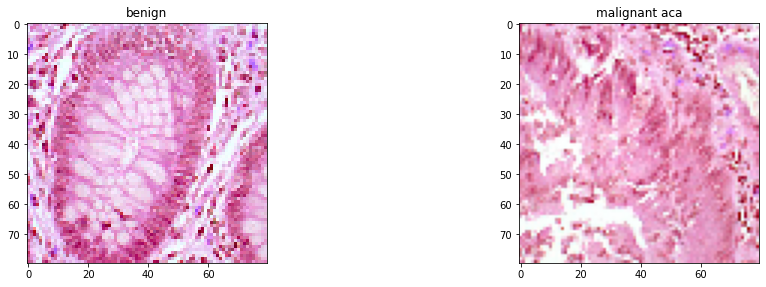

In [6]:
indices = [0, 40, 2300]

plt.figure(1, figsize=(25,15))
plt.grid(None)

for n, idx in enumerate(indices):
    plt.subplot(n+1, 3, 1) 
    plt.imshow(benign[idx])
    plt.title('benign')
    plt.subplot(n+1, 3, 2) 
    plt.imshow(mal_aca[idx])
    plt.title('malignant aca')

plt.show()

In [7]:
samples = np.concatenate((benign, mal_aca))
labels = np.array(benign.shape[0] * [0] + mal_aca.shape[0] * [1] )

In [8]:
print(f"Samples shape check: {samples.shape}.")
print(f"Labels shape check: {labels.shape}.")

Samples shape check: (10000, 80, 80, 3).
Labels shape check: (10000,).


In [9]:
indices = np.arange(samples.shape[0])
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

# normalize pictures
samples = samples.astype('float32') / 255

In [10]:
import sklearn as sk
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [11]:
Y_train = np_utils.to_categorical(y_train, 3)
Y_val = np_utils.to_categorical(y_val, 3)
Y_test = np_utils.to_categorical(y_test, 3)

print(Y_train[0])
print(f"Y_train shape after one hot encoding: {Y_val.shape}")
print(f"Y_train shape after one hot encoding: {X_val.shape}")

[0. 1. 0.]
Y_train shape after one hot encoding: (1000, 3)
Y_train shape after one hot encoding: (1000, 80, 80, 3)


In [12]:
def base_model(input_shape=(80,80,3), classes = 3):
    inputs = Input(shape=input_shape)

    X = Conv2D(32, 3, 3, activation='relu')(inputs)
    X = MaxPooling2D(pool_size=(2,2))(X)

    X = Conv2D(64, 3, 3, activation='relu')(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    X = Dropout(0.2)(X)

    X = Conv2D(128, 3, 3, activation='relu', padding='same')(X)
    X = MaxPooling2D(pool_size=(2,2), padding='same')(X)
    X = Dropout(0.2)(X)

    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    outputs = Dense(classes, activation='softmax')(X)

    model = Model(inputs, outputs)
    
    return model

In [13]:
model = base_model(input_shape=(80,80,3), classes=3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         73856 

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [15]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=25, validation_data=(X_val, Y_val))

Epoch 1/25
125/125 [==============================] - 19s 9ms/step - loss: 0.7147 - accuracy: 0.5086 - val_loss: 0.6925 - val_accuracy: 0.4780
Epoch 2/25
125/125 [==============================] - 1s 7ms/step - loss: 0.6135 - accuracy: 0.6539 - val_loss: 0.4923 - val_accuracy: 0.7760
Epoch 3/25
125/125 [==============================] - 1s 7ms/step - loss: 0.4877 - accuracy: 0.7621 - val_loss: 0.3745 - val_accuracy: 0.8430
Epoch 4/25
125/125 [==============================] - 1s 7ms/step - loss: 0.3897 - accuracy: 0.8219 - val_loss: 0.3222 - val_accuracy: 0.8510
Epoch 5/25
125/125 [==============================] - 1s 7ms/step - loss: 0.3618 - accuracy: 0.8411 - val_loss: 0.3059 - val_accuracy: 0.8800
Epoch 6/25
125/125 [==============================] - 1s 7ms/step - loss: 0.3205 - accuracy: 0.8608 - val_loss: 0.2569 - val_accuracy: 0.8860
Epoch 7/25
125/125 [==============================] - 1s 7ms/step - loss: 0.2515 - accuracy: 0.8951 - val_loss: 0.2446 - val_accuracy: 0.9000
Epoch

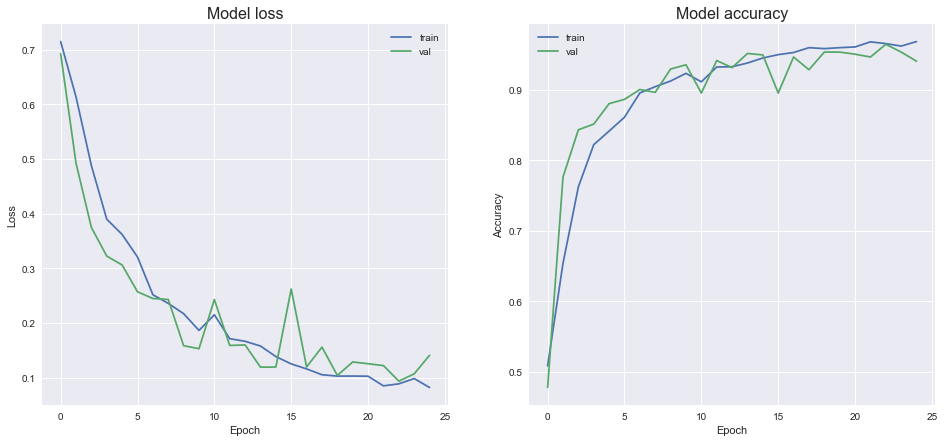

In [16]:
plt.style.use('seaborn')
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model loss', fontsize=16)  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy', fontsize=16)  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [18]:
y_pred_test = model.predict(X_test, verbose=1)
y_pred_train = model.predict(X_train, verbose=1)

# conversion to one hot encoding
#y_pred_test = (y_pred_test > 0.5).astype("int32")
#y_pred_train = (y_pred_train > 0.5).astype("int32")

# convert it to numerical classes
y_pred_test = np.argmax(y_pred_test, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

score_test = model.evaluate(X_test, Y_test)
print(f"Train accuracy: {history.history['accuracy'][-1]:.3f}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {score_test[1]:.3f}")

32/32 [==============================] - 0s 3ms/step - loss: 0.1285 - accuracy: 0.9540
Train accuracy: 0.968
Validation accuracy: 0.940
Test accuracy: 0.954


<AxesSubplot:>

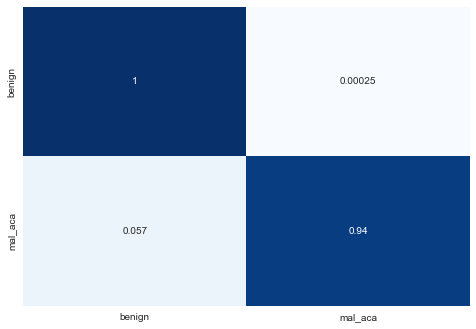

In [19]:
label_names = ['benign', 'mal_aca']


confmat = confusion_matrix(y_train, y_pred_train, normalize='true')
sn.heatmap(confmat, annot=True, cmap='Blues', cbar=False, 
           xticklabels=label_names, yticklabels=label_names)

# Wrongly classified samples

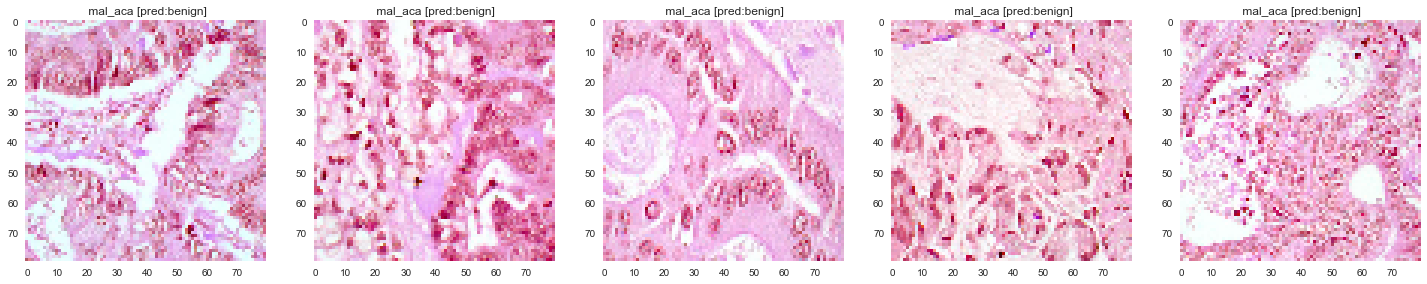

In [20]:
mistakes = np.where(y_pred_train != y_train)[0]

n = 5

plt.figure(figsize=(5*n,5))

# get 5 random false negatives
for i, val in enumerate(np.random.choice(mistakes, n)):

    plt.subplot(1,n,i+1)
    plt.imshow(X_train[val])
    plt.title(f" {label_names[y_train[val]]} [pred:{label_names[y_pred_train[val]]}]", fontsize=12)
    plt.grid(None)

# ResNet50

In [21]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block 
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    

    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding='same', name= conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis =3, name= bn_name_base + '2c')(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [22]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same',name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1,1), strides = (1,1), padding='valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding='valid', name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [23]:
def ResNet50(input_shape=(80, 80, 3), classes=3):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    

    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)


    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, 3, [128,128,512], stage=3, s=2, block='a')
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    X = convolutional_block(X, 3, [256,256,1024], stage=4, s=2, block='a')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')    

  
    X = convolutional_block(X, 3, [512,512,2048], stage=5, s=2, block='a')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')

  
    X = AveragePooling2D(pool_size=(2, 2), name="avg_pool")(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [24]:
from keras.initializers import glorot_uniform
resmodel = ResNet50(input_shape=(80, 80, 3), classes=3)

In [25]:
resmodel.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 86, 86, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 40, 40, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [26]:
resmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [27]:
resmodel.fit(X_train, Y_train, batch_size = 64, epochs = 10, validation_data=(X_val, Y_val))

Epoch 1/10
125/125 [==============================] - 27s 172ms/step - loss: 0.5385 - accuracy: 0.8581 - val_loss: 2.6172 - val_accuracy: 0.4780
Epoch 2/10
125/125 [==============================] - 21s 168ms/step - loss: 0.0669 - accuracy: 0.9750 - val_loss: 4.9342 - val_accuracy: 0.4780
Epoch 3/10
125/125 [==============================] - 21s 168ms/step - loss: 0.0288 - accuracy: 0.9889 - val_loss: 6.1209 - val_accuracy: 0.4780
Epoch 4/10
125/125 [==============================] - 21s 168ms/step - loss: 0.0421 - accuracy: 0.9851 - val_loss: 4.9876 - val_accuracy: 0.4780
Epoch 5/10
125/125 [==============================] - 21s 169ms/step - loss: 0.0176 - accuracy: 0.9934 - val_loss: 0.5623 - val_accuracy: 0.8980
Epoch 6/10
125/125 [==============================] - 21s 169ms/step - loss: 0.0073 - accuracy: 0.9973 - val_loss: 2.5155 - val_accuracy: 0.5270
Epoch 7/10
125/125 [==============================] - 21s 169ms/step - loss: 0.0109 - accuracy: 0.9959 - val_loss: 1.4278 - val_ac